In [1]:
# importing libs
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, GaussianNoise, Lambda
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras import backend as K
import random as rn

def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

Using TensorFlow backend.


In [2]:
# defining parameters
k = 4
M = 2**k
# k = np.log2(M)
# k = int(k)
n_channel = 2
R = k/n_channel
print ('M:',M,'k:',k, "n: ", n_channel, "R: ", R)

EbNodB_range = list(frange(0,14,0.5))

M: 16 k: 4 n:  2 R:  2.0


NameError: name 'frange' is not defined

In [3]:
tf.set_random_seed(14)
rn.seed(14)
np.random.seed(14)

In [4]:
#generating data of size N
N = 10000
label = np.random.randint(M,size=N)

In [5]:
# creating one hot encoded vectors
data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)

In [6]:
data = np.array(data)
print (data.shape)

(10000, 16)


In [7]:
temp_check = [17,23,45,67,89,96,72,250,350]
for i in temp_check:
    print(label[i],data[i])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
10 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
11 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
# print (int(k/R))
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(n_channel, activation='linear')(encoded)
encoded2 = BatchNormalization(center=False, scale=False)(encoded1)
#encoded2 = Lambda(lambda x: 2.0/np.sqrt(2)*K.l2_normalize(x,axis=-1))(encoded1)

EbNo_train = 5.01187 #  coverted 7 db of EbNo
encoded3 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded2)

decoded = Dense(M, activation='relu')(encoded3)
decoded1 = Dense(M, activation='softmax')(decoded)

autoencoder = Model(input_signal, decoded1)
#sgd = SGD(lr=0.001)
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
print (autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
batch_normalization_1 (Batch (None, 2)                 4         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272 

In [10]:
N_val = 1500
val_label = np.random.randint(M,size=N_val)
val_data = []
for i in val_label:
    temp = np.zeros(M)
    temp[i] = 1
    val_data.append(temp)
val_data = np.array(val_data)

In [11]:
autoencoder.fit(data, data,
                epochs=1000,
                batch_size=300,
                validation_data=(val_data, val_data))

- val_loss: 0.0020
Epoch 816/1000
10000/10000 [==============================] - 0s 3us/step - loss: 0.1852 - val_loss: 0.0021
Epoch 817/1000
10000/10000 [==============================] - 0s 3us/step - loss: 0.1965 - val_loss: 0.0022
Epoch 818/1000
10000/10000 [==============================] - 0s 3us/step - loss: 0.1966 - val_loss: 0.0020
Epoch 819/1000
10000/10000 [==============================] - 0s 3us/step - loss: 0.1856 - val_loss: 0.0020
Epoch 820/1000
10000/10000 [==============================] - 0s 3us/step - loss: 0.1871 - val_loss: 0.0020
Epoch 821/1000
10000/10000 [==============================] - 0s 3us/step - loss: 0.1963 - val_loss: 0.0021
Epoch 822/1000
10000/10000 [==============================] - 0s 3us/step - loss: 0.1959 - val_loss: 0.0021
Epoch 823/1000
10000/10000 [==============================] - 0s 3us/step - loss: 0.1848 - val_loss: 0.0020
Epoch 824/1000
10000/10000 [==============================] - 0s 3us/step - loss: 0.1818 - val_loss: 0.0020
Epoch 825

In [12]:
from keras.models import load_model
#autoencoder.save('4_7_symbol_autoencoder_v_best.model')

In [13]:
#autoencoder_loaded = load_model('4_7_symbol_autoencoder_v_best.model')

In [14]:
encoder = Model(input_signal, encoded2)

In [15]:
encoded_input = Input(shape=(n_channel,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
# create the decoder model
decoder = Model(encoded_input, deco)

In [16]:
N = 45000
test_label = np.random.randint(M,size=N)
test_data = []

for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)

In [17]:
temp_test = 6
print (test_data[temp_test][test_label[temp_test]],test_label[temp_test])

1.0 2


In [18]:
autoencoder

In [19]:
EbNodB_range = list(frange(0,14,0.5))
ber = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    noise = noise_std * np.random.randn(nn,n_channel)
    encoded_signal = encoder.predict(test_data) 
    final_signal = encoded_signal + noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber[n])

NameError: name 'frange' is not defined

In [20]:
import matplotlib.pyplot as plt
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder({}, {})'.format(n_channel, k))
#plt.plot(list(EbNodB_range), ber_theory, 'ro-',label='BPSK BER')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)

NameError: name 'EbNodB_range' is not defined

In [21]:
plt.savefig('AutoEncoder_{}_{}_BER_matplotlib'.format(n_channel, k))
plt.show()

<Figure size 432x288 with 0 Axes>

In [22]:
scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
scatter_plot = 1.5/2*np.array(scatter_plot)


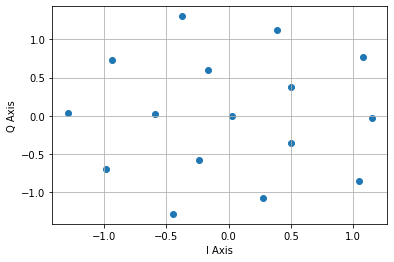

In [23]:
# ploting constellation diagram
import matplotlib.pyplot as plt
scatter_plot = scatter_plot.reshape(M,2,1)
plt.scatter(scatter_plot[:,0, :],scatter_plot[:,1, :])
#plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.xlabel('I Axis')
plt.ylabel('Q Axis')
plt.show()

In [24]:
scatter_plot.shape

(16, 2, 1)